In [1]:
! pip install -Uqq fastai duckduckgo_search nbdev fastbook

In [2]:
import fastbook # needed to support doc() for now, we'll use a better dep later
fastbook.setup_book()

In [3]:
#|default_exp model

In [2]:
#|export
# TODO: probably none of this is needed in the exported model
from fastbook import *
from nbdev import *
from fastai.vision.widgets import *
from duckduckgo_search import ddg_images

doc(print)

In [5]:
def find_images(query, max_results=10):
  result = ddg_images(query, max_results=max_results)
  return L(result).itemgot("image")


In [8]:
img_src=find_images("black crow on a pink background", 1)[0]

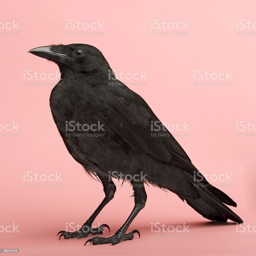

In [9]:
from fastdownload import download_url
from fastai.vision.all import *

dest="test-image.jpg"
download_url(img_src, dest, show_progress=False)

img = Image.open(dest)
img.to_thumb(256)


In [11]:
searches="crow", "raven"
path=Path("images")


for name in searches:
  print(f"Preparing data for {name}:")
  dest = path/name
  # shutil.rmtree(dest)
  dest.mkdir(exist_ok=True, parents=True)
  images=find_images(name, 100)
  download_images(dest, urls=images)
  resize_images(dest, max_size=400, dest=dest)
  print(f"Dowloaded {len(images)} images. Sleeping...")
  time.sleep(3)
  print("OK, moving to the next label.")

print(f"Found and downloaded {len(get_image_files(path))} images.")


Preparing data for crow:
Dowloaded 100 images. Sleeping...
OK, moving to the next label.
Preparing data for raven:
Dowloaded 100 images. Sleeping...
OK, moving to the next label.
Found and downloaded 193 images.


In [12]:
failed=verify_images(get_image_files(path))

print(f"Found {len(failed)} invalid images. Removing...")
failed.map(Path.unlink)

Found 1 invalid images. Removing...


(#1) [None]

In [3]:
data_loaders=DataBlock(
    # Define data structure [x: data, y: labels]
    blocks=[ImageBlock, CategoryBlock],
    # how to get the assets
    # `get_image_files` will be called with the path arg passed in .dataloaders()
    get_items=get_image_files, 
    # set aside a validation Set
    splitter=RandomSplitter(valid_pct=.2, seed=666),
    # how to get the labels?
    get_y=parent_label,
    # item_tfms=[Resize(192, method="squish")]
    # using 224 for historical reasons (the og model was trained in this size)
    item_tfms=[RandomResizedCrop(224, min_scale=.3)],
    batch_tfms=aug_transforms() # data augmentation
).dataloaders(path, bs=32) # bs == batch size

data_loaders.train.show_batch(max_n=10, nrows=2, unique=True) # unique == show for the same image

NameError: name 'path' is not defined

In [98]:
learn = vision_learner(data_loaders, resnet34, metrics=error_rate)
learn.fine_tune(4)

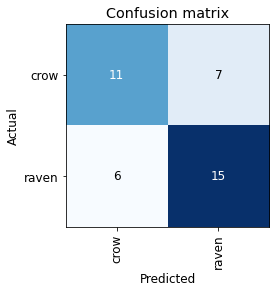

In [89]:
interpretation=ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

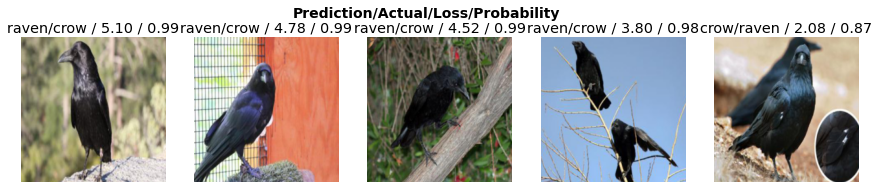

In [90]:
interpretation.plot_top_losses(5, nrows=1)

In [91]:
cleaner=ImageClassifierCleaner(learn)
cleaner

In [95]:
print(f"To change: {cleaner.change()}")
print(f"To delete: {cleaner.delete()}")


for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)


To change: [(0, 'raven'), (1, 'raven'), (8, 'raven')]
To delete: [5]


## Exporting the model

In [99]:
%time learn.export()

print(f"Exported model: {Path().ls(file_exts='.pkl')}")

CPU times: user 128 ms, sys: 93 ms, total: 221 ms
Wall time: 249 ms
Exported model: [Path('export.pkl')]


In [100]:
upload_btn=widgets.FileUpload()
upload_btn

FileUpload(value={}, description='Upload')

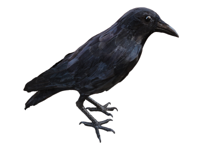

In [101]:
test_img=PILImage.create(upload_btn.data[-1])
test_img.to_thumb(200)

In [105]:
#|export
learn_exported=load_learner(Path()/'export.pkl')
categories='crow', 'raven'

In [110]:

# doc(learn_exported.predict)
result=learn_exported.predict(test_img)

# (predicted cat, predicted cat index, probabilities for each cat)
prediction, ind, probabilities = result
# print(result)
print(f"🪶 We're {probabilities[ind]:.1%} sure it's a {prediction}.")

🪶 We're 88.6% sure it's a raven.


In [111]:
#|export
def classify_image(img):
  pred, idx, probs = learn_exported.predict(img)
  return dict(zip(categories, map(float, probs)))


In [120]:
test_img=PILImage.create('test-image.jpg') # Image doesn't work
classify_image(upload_btn.data[-1])

{'crow': 0.11436481028795242, 'raven': 0.8856351971626282}

In [122]:
!pip install -Uqq gradio

     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 112 kB 89.7 MB/s 
     |████████████████████████████████| 212 kB 69.2 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 2.3 MB 67.8 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 57 kB 6.3 MB/s 
     |████████████████████████████████| 270 kB 84.9 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
     |████████████████████████████████| 80 kB 12.0 MB/s 
     |████████████████████████████████| 68 kB 8.6 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 4.0 MB 70.8 MB/s 
     |████████████████████████████████| 856 kB 77.5 MB/s 
     |████████████████████████████████| 593 kB 87.9 MB/s 


In [ ]:
# #|export
# import gradio as gr
# image=gr.inputs.Image(shape=(192,192))
# label=gr.outputs.Label()
# # examples=[]

# ui=gr.Interface(fn=classify_image, inputs=image, outputs=label)
# ui.launch()

In [ ]:
#|export
def hello_world(name): 
    return f"🌏 Hello {name} 🌎"

In [44]:
from nbdev import export

export.nb_export('publish_model.ipynb')

### TODO: https://www.kaggle.com/code/rafalpast/kaggle-exercise-1
and export, publish